# visualisation

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
# from PIL import Image
# from matplotlib.pyplot import imshow
# import matplotlib

from skimage import color
from skimage import io

# import random

import sys, os
sys.path.append('..')
import src.visual as visual
# import ..src.visual as visual

# Dataframe load

In [2]:
books_df = visual.clean_books_df('../data/big_data_temp/')

Pattern : gr_books_df_*.csv
6


In [3]:
# Tfidf
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(books_df['genres'])

# tf.stop_words_
# tf.vocabulary_
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tf.get_feature_names())
books_df = pd.concat([books_df, tfidf_df], axis=1)
features = tf.get_feature_names()

# KMeans clustering

In [4]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(tfidf_df)
labels = kmeans.labels_

tfidf_df['labels'] = labels
books_df['labels'] = labels

books_num = tfidf_df[['19th_century','labels']].groupby('labels').count()
books_num

text_df = books_df[['genres', 'labels']].groupby('labels').sum()

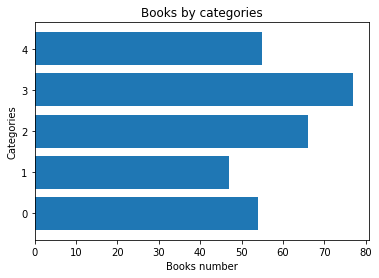

In [5]:
fig, ax = plt.subplots()
ax.barh(books_num.index, books_num['19th_century'], align='center')
ax.set_yticks(books_num.index)
# ax.set_yticklabels()
# ax.invert_yaxis()  # labels read top-to-bottom
ax.set_ylabel('Categories')
ax.set_xlabel('Books number')
ax.set_title('Books by categories')

plt.show()

# Word Cloud

In [6]:
all_genres = list(books_df[books_df['labels']==0]['genres'])
text = ''
for el in all_genres:
    text += " " + el
text = text.strip()
words_to_remove = [' audiobook ', ' science ', ' popular_science ', ' nonfiction ']
for word in words_to_remove:
    text = text.replace(word, ' ', 500)

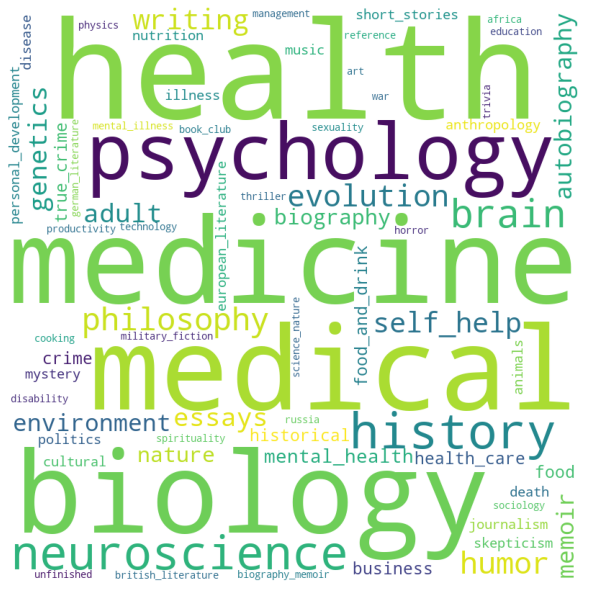

In [7]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', margin=2,
                      collocations=False,
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

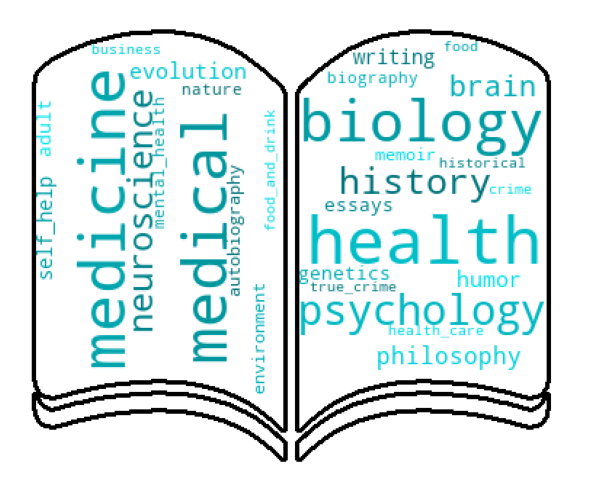

In [8]:
img = color.rgb2gray(io.imread('../img/book.jpg')) * 255

img1 = color.rgb2gray(io.imread('../img/a_book_slide.png')) * 255

img[img>10] = 255
img[img<=10] = 0

transformed_img1 = np.ndarray((img1.shape[0],img1.shape[1]), np.int32)

for i in range(len(img1)):
    transformed_img1[i] = list(map(visual.transform_format, img1[i]))
    
wc = WordCloud(background_color="white", max_words=1000, 
               mask=transformed_img1,
               contour_width=3,  
               collocations=False, 
               min_font_size = 10,
               color_func=visual.blue_color_func)

# Generate a wordcloud
wc.generate(text)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

wc.to_file("../img/word_cloud_book_0.png")


# Word counts by category

In [10]:
# Word count
wf = CountVectorizer(analyzer='word', ngram_range=(1, 1), 
                     min_df=0, stop_words='english')
wf_matrix = wf.fit_transform(books_df['genres'])

wf_df = pd.DataFrame(wf_matrix.toarray(), 
                     columns=wf.get_feature_names())
# word_counts_df = pd.concat([books, wf_df], axis=1)
wf_features = wf.get_feature_names()

wf_df['labels'] = labels

scores = visual.display_scores(wf, wf_matrix)

scores_dct = {}
for k, v in scores:
    scores_dct[k] = v

word_counts_by_label = wf_df.groupby(labels).sum()

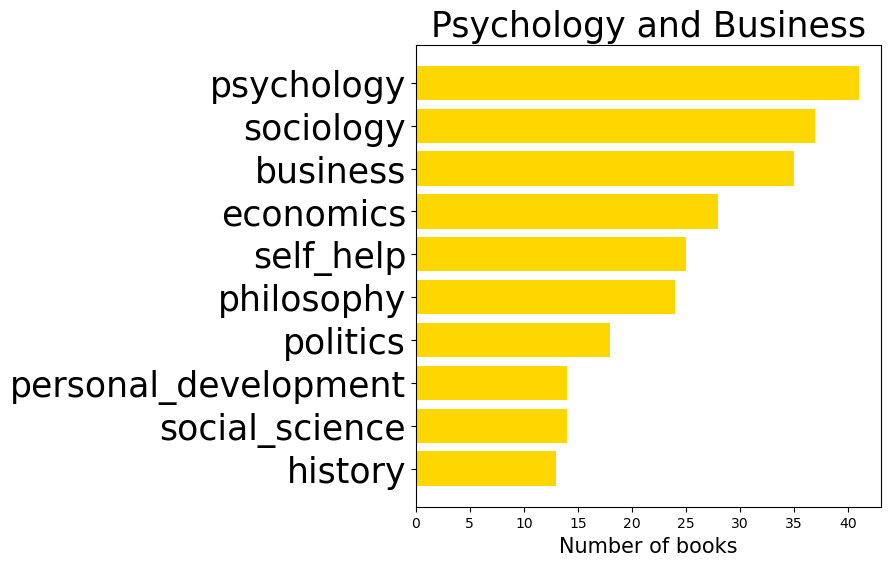

In [13]:
i=1

colors = ['c','gold']

categories = ['Health and Medicine', 'Psychology and Business', 'Space and Technology', 
              'Nature and Biology', 'History and Philosophy']

scores_wc = visual.display_scores_wc(np.array(word_counts_by_label.loc[i]), wf_features)

words_to_remove = ['audiobook', 'science', 'popular_science', 'nonfiction', 'unfinished']
dct_wc = {}
for k,v in scores_wc:
    if k in words_to_remove:
        continue
    else: 
        dct_wc[k] = v
dct_wc.values()

plt.rcdefaults()
fig, ax = plt.subplots(figsize=[6,6])

# Example data
n=10

genres = list(dct_wc.keys())[:n]
y_pos = np.arange(len(genres))

ax.barh(y_pos, list(dct_wc.values())[:n],  align='center', color='gold')
ax.set_yticks(y_pos)
ax.set_yticklabels(genres, fontsize=25)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of books', fontsize=15)
ax.set_title(f'{categories[i]}', fontsize=25)
# plt.set_fontsize(20)

plt.savefig(f'../img/bar_cat_{i}.png')
plt.show()

#### 